#### Física de la Radioterapia. Master de Física Biomédica. Universidad Complutense de Madrid
# Visualización de tratamientos de radioterapia
## Distribuciones de dosis absorbida
-----
*Este cuaderno modifica el código de los cuadernos de ejemplo del módulo [scikit-rt](https://scikit-rt.github.io/scikit-rt/examples.html)*

Los datos corresponden a una paciente real tratada en el Hospital de Fuenlabrada.

Han sido anonimizados de acuerdo a procedimientos validados.

**Objetivos**: 

* Mostrar elementos que aparecen en la planificación de un tratamiento de radioterapia

* Comprender las bases radiobiológicas del fraccionamiento de la dosis en radioterapia

## Fundamentos

Los conceptos básicos sobre los que se trabajará en este cuaderno corresponden a un tratamiento de mama, una de las patologías que con más frecuencia se trata en los Servicios de Radioterapia, pero son aplicables en general a cualquier otra patología. 

En el tratamiento del cáncer de mama la radioterapia se emplea como tratamiento adyuvante a la cirugía. El tumor primario se extirpa y posteriormente se administra una dosis de radiación sobre el lecho tumoral y sobre el resto de la mama.

Definiendo un volumen de tratamiento que comprenda el lecho tumoral más un margen para incluir la posible enfermedad microscópica, la experiencia clínica apunta a que se tiene una alta probabilidad de éxito en el tratamiento si la dosis que se administra a ese volumen es de 60 Gy en 30 fracciones. Sobre el volumen que cubre toda la mama la dosis administrada debe ser de 50 Gy en 25 fracciones.

Los efectos adversos del tratamiento se cuantifican fundamentalmente por la dosis que reciba el pulmón ipsilateral, siendo un buen indicador predictivo el porcentaje de volumen que recibe una dosis de 20 Gy o superior en relación al volumen total de ese pulmón. Se considera tolerable un tratamiento en el que el volumen de pulmón que recibe 20 Gy es inferior al 25\% del volumen total. Otro efecto adverso es la aparición de radiodermitis por respuesta aguda de la piel a la radiación. Este efecto es controlado directamente por el oncólogo de radioterapia mediante revisiones en consulta durante el curso del tratamiento. En casos graves puede complicar el desarrollo del tratamiento obligando a parar y descansar durante un tiempo.

La manera convencional de aplicar el tratamiento es hacerlo de manera secuencial. Durante 25 fracciones se irradia la mama completa para generar una distribución de dosis todo lo uniforme posible procurando evitar el pulmón. El valor medio de esa distribución de dosis será de 50 Gy y la dispersión de la dosis debe ser tal que no más de un 5\% de la mama reciba más de 53.5 Gy ni más de un 5\% de la mama reciba menos de un 47.5 Gy, o dicho en términos relativos, el 95\% del volumen de la mama recibe al menos el 95\% de la dosis de prescripción y no más del 5\% del volumen de la mama recibe más del 107\% de la dosis de prescripción. A continuación se administraran otras cinco fracciones en las se procurará irradiar únicamente el volumen del lecho tumoral hasta que en este volumen se tenga una distribución de dosis con un valor medio de 60 Gy y de nuevo con una dispersión tal que se cumplan los criterios del 5\% aplicados al 95\% y al 107\% de la dosis de prescripción. En el argot de la radioterapia a la irradiación del volumen reducido se la denomina *Boost* o Sobreimpresión.

Los avances técnicos han permitido realizar el tratamiento de manera concurrente. Los dos volúmenes se irradian en el mismo número de sesiones prescribiendo diferente dosis por sesión en cada uno de ellos. El tratamiento se acorta en el tiempo y la distribución de dosis se optimiza en mayor medida. La tendencia actual es realizar los tratamientos en menos fracciones.

En radioterapia la evaluación de los planes de tratamiento se realiza mediante mapas de dosis sobre cortes tomográficos e histogramas dosis volumen (DVH). Los oncólogos de radioterapia valoran la conformación de la dosis a los volúmenes de tratamiento y la protección de las estructuras de riesgo. Los DVH reducen la información de la distribución de dosis permitiendo evaluar la cantidad de volumen irradiado con una dosis dada. Lo habitual es presentarlos como histogramas acumulados invertidos de manera que cada punto del histograma nos da el volumen que recibe al menos la dosis considerada.

## Visualización de distribuciones de dosis

Esta primera parte del cuaderno emplea el módulo python `scikit-rt` para generar gráficos interactivos que permiten visualizar distribuciones de dosis empleadas en radioterapia.

Todos los sistemas de planificación de radioterapia ofrecen estas mismas representaciones. Los gráficos presentados aquí son menos versátiles que los de los programas de planificación pero básicamente tienen la misma funcionalidad.

Se asume que estamos corriendo el cuaderno en `jupyterlab`, bien sea en la distribución proporcionada en `mybinder` o en una instalación local.

Comenzamos por importar una serie de módulos que nos harán falta y por configurar algunas opciones

In [1]:
from skrt import Dose, Patient
from skrt.core import get_data_by_filename
import gdown

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Set scikit-rt viewer options.
options = {}
# Make display interactive ("no_ui": False) or non-interactive ("no_ui": True).
options["no_ui"] = False
# Include the interface for interactive zooming.
options["zoom_ui"] = not options["no_ui"]
# Use centre left of legend as reference point for fixing its location.
options["legend_loc"] = "center left"
# Set coordinates of legend reference point,
# in system where image axes extend from 0 to 1.
options["legend_bbox_to_anchor"] = (1.8, 0.5)
# Set figure size in inches.
options["figsize"] = (13, 6)
# Overlay default image annotation (slice z-coordinate), in white, at default position (top left or image).
options["annotate_slice"] = {"color": "white", "fontsize": 24}

### Subida de datos 

Los datos de la paciente con las imágenes de CT, estructuras anatómicas relevantes, planes de radioterapia y distribuciones de dosis, se han comprimido y compartido en un archivo zip disponible en [Google Drive](https://drive.google.com/file/d/1ICECuwHhMBoMwioQ96-UpkV43v0kNneI/view?usp=sharing).

Al ejecutar el código de la siguiente celda se coloca toda la información de la paciente en la carpeta `data/MamaDer001`

In [2]:
# Descargar los datos compartidos de Google Drive
url = 'https://drive.google.com/file/d/1ICECuwHhMBoMwioQ96-UpkV43v0kNneI/view?usp=sharing'
output = '../data/MamaDer001.zip'
gdown.download(url, output, quiet=False, fuzzy=True)

# Descomprimir el archivo zip
!bash ../shell_scripts/preparar_datos > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1ICECuwHhMBoMwioQ96-UpkV43v0kNneI
To: /home/jovyan/data/MamaDer001.zip
100%|██████████| 22.0M/22.0M [00:00<00:00, 68.9MB/s]


Leer los datos de la paciente e identificar los planes de tratamiento y sus correspondientes distribuciones de dosis:
- *Secuencial*: compuesto por **mama** y **boost**. La combinación de ambos corresponde al plan **suma**
- *Concurrente*: plan **SIB** del inglés **S**imultaneous **I**ntegrated **B**oost

In [3]:
patient = Patient('../data/MamaDer001', unsorted_dicom=True)
(suma, boost, SIB, mama) = (0, 1, 2, 3)

Al ejecutar la siguiente celda se generara un gráfico interactivo que nos permite visualizar las distribuciones de dosis correspondientes a los diferentes esquemas de tratamiento. 

- Para seleccionar un esquema dado basta con modificar el `plan_ID`asociado
- Para visualizar planos axiales tiene que estar seleccionado `x-y` en `Slice plane selection`
- Hacer visible la segmentación de las estructuras anatómicas relevantes. Seleccionar una opción en `ROI plotting` distinta de `none`. Lo habitual en Radioterapia es trabajar en la opción `contour`
- Hacer visible la distribución de dosis mediante el control `Dose opacity`
- Seleccionar las estructuras relevantes para lo que vamos a trabajar en este cuaderno: PTV boost dcho, PTV mama dcha, Pulmon Dcho.
- Hacer `Zoom` y centrar la imagen en las regiones que se irradian directamente mediante los controles `x centre (mm)` e `y centre (mm)`. La figura debería mostrar una imagen similar a esta
![image](../images/zoom.png)
- Desplazarse en la dirección craneo caudal cambiando el valor del control `z (mm)`. Una vez seleccionado este control los cursores del teclado nos permiten desplazarnos corte a corte del estudio de CT.

In [6]:
plan_ID = suma# Para representar otras distribuciones de dosis cambiar el plan_ID seleccionando (mama, boost, suma, SIB)
# Obtain references to selected objects.
ct = patient.studies[0].ct_images[0]
dose = patient.studies[0].ct_doses[plan_ID]
plan = patient.studies[0].ct_plans[plan_ID]
plan.load_constraints()
ss1 = patient.studies[0].ct_structure_sets[0]
ss1.set_image(ct)
ss1.name = "plan"
dose.resample(voxel_size=ct.voxel_size)
dose.origin = ct.origin
# Set options differently depending on whether notebook is to be used interactively.
roi_plot_type = "contour" if options["no_ui"] else "none"
dose_opacity = 0.5 if options["no_ui"] else None

# Display image and associated data.
ct.view(dose=dose, rois=ss1, roi_plot_type=roi_plot_type, legend=True,
        colorbar=2, dose_opacity=dose_opacity, **options);

Output()

#### Cuestiones

1. Desplazándose por las imágenes de CT determinar cuál es la extensión en la dirección craneo caudal de
- **PTV mama dcha:** Comienza en $z_0=15 \pm 5$ mm y termina en $z_f=190 \pm 5$ mm, lo que hace una extensión de 175 mm.
- **PTV boost dcho:** Comienza en $z_0=110 \pm 5$ mm y termina en $z_f=150 \pm 5$ mm, dando una extensión de 40 mm.
- **Pulmón dcho:** Comienza en $z_0=35 \pm 5$ mm y termina en $z_f=220 \pm 5$ mm, teniendo una extensión de 185 mm.

En las imágenes se pueden apreciar unos objetos brillantes colocados sobre la superficie de la paciente. Sirven para señalar la cicatriz resultado de la intervención quirúrgica previa a la radioterapia.

2. **Determinar la extensión de la cicatriz en la dirección craneo caudal.** Las marcas de la cicatriz comienzan a verse en $z_0=80 \pm 5$ mm y llega hasta $z_f=115 \pm 5$ mm, por lo que tiene una extensión de 35 mm.
1. **Indicar si la posición de la cicatriz en la mama coincide con el volumen de PTV boost dcho.** No, la cicatriz es más pequeña que el boost, además, se encuentra más abajo. Esto puede ser que la operación se realizara entorno al pezón para que la cicatriz fuera más discreta.
1. **¿Qué estructura tiene mayor extensión la cicatriz o el PTV boost dcho? Comentar qué razones pensamos que motivan esta diferencia de extensión.** La extensión de la cicatriz es ligeramente menor que el PTV boost derecho, aunque incluyendo el rango de error podrían llegar a tener el mismo tamaño. Esto puede ser porque no fue necesario abrir más para localizar correctamente el tumor.

Dentro de la mama se pueden apreciar puntos brillantes que claramente no son de origen natural. Son grapas quirúrgicas.

5. **Indicar en qué cortes tomográgicos se ven grapas:** Las grapas se pueden apreciar en dos rangos diferentes, entre $120-135 \pm 5$ y $155-160 \pm 5$.
1. **¿Se encuentran todas las grapas dentro del volumen PTV boost dcho? Comentar la relación entre la posición de las grapas y la del PTV boost.** Las grapas correspondientes al primer tramo sí están incluidas dentro del volumen PTV boost derecho, pero el segundo tramo no, justo por encima. Las que se encuentran dentro del PTV boost derecho, debido a su ubicación, muy probablemente son debidas a la operación de extirpación. Las otras grapas que están por encima pueden ser debidas a una incisión realizada durante la operación para localizar correctamente el tumor, o bien de una operación anterior.
1. **Cambiando en el gráfico el `plan_ID` entre `{mama, boost, suma}` para cada uno de los planes describir, de forma aproximada, la extensión de los niveles de dosis de tratamiento explicados en la sección *Fundamentos* e indicar si se cubren los volúmenes de tratamiento.** 
- *Plan_ID de la mama:* Abarca un rango de 0-50 Gy. Para PTV mama derecha, recibe en todo su volumen la radiación máxima, 50 Gy. El pulmón derecho recibe dosis en su parte más cercana a la PTV (en torno a una quinta parte de su volumen) la dosis de 50 Gy. Gradualmente va bajando según se aleja del PTV de la mama, haciendo que la mayoría de su volumen no reciba radiación, como mucho en la mitad del volumen 10 Gy. A partir de 180 mm, donde ya ambas partes están más alejadas, el pulmón casi no recibe radiación. En cuanto al PTV boost derecho, como está incluido dentro del PTV mama derecha, recibe en todo su volumen 50 Gy.
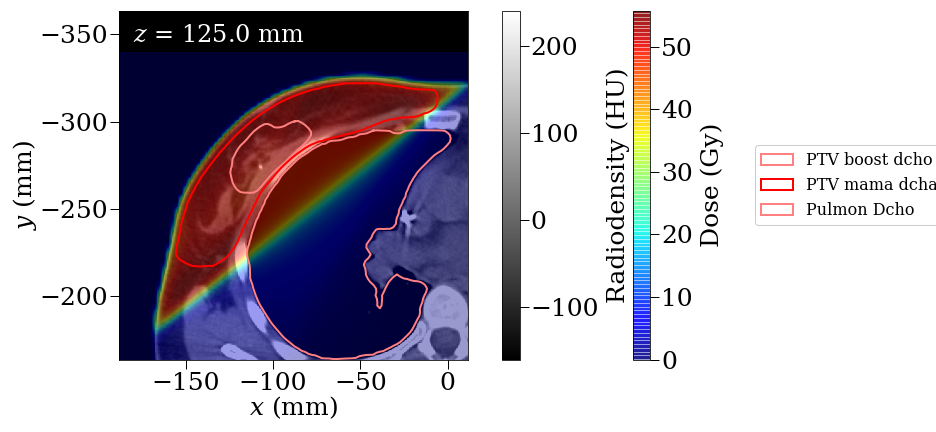
- *Plan_ID del boost:* En este caso, la radiación en el PTV de la mama derecha empieza en torno a 105 mm, con una dosis de aproximadamente 6 Gy en unos 2/3 del volumen. El máximo se encuentra más o menos en z=135 mm, y es de 10 Gy, cubriendo el volumen completo del PTV boost derecho. Momento en el cuál no llega a abarcar todo el volumen de la mama, en cuyos extremos hay un máximo de 2 Gy. Respecto al pulmón, solo le llega en la zona más cercana el mínimo de radiación, que son también unos 2 Gy.
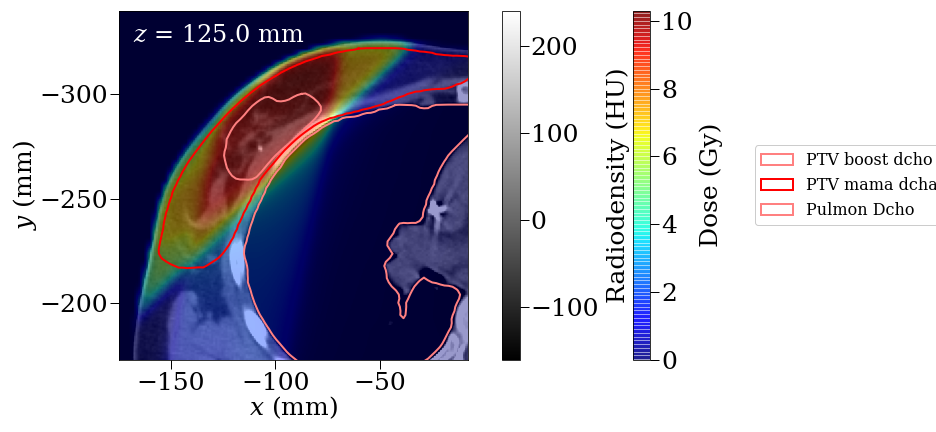
- *Plan_ID suma:* En este caso, se abarca el rango de 0 a 60 Gy. Cubriendo practicamente todo el volumen de la mama, sobretodo en el PTV boost derecho, que recibe los 60 Gy en todo su volumen. En los bordes de la mama es más bien 50 Gy. En el pulmón sucede más o menos lo mismo que en el caso del Plan_ID de la mama, con un máximo de 50 Gy en la zona más cercana. 
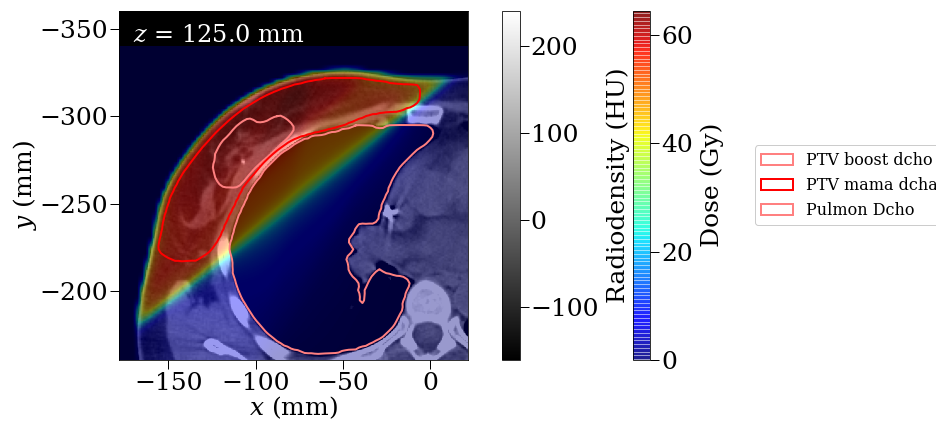
1. **Seleccionando como `plan_ID` `SIB` realizar a partir de la figura una primera estimación de las dosis de tratamiento en el PTV mama dcha y el PTV boost dcho:** Para el PTV mama derecha hay aproximadamente una dosis general de 40-45 Gy, mientras que en el PTV boost derecho hay 50 Gy.
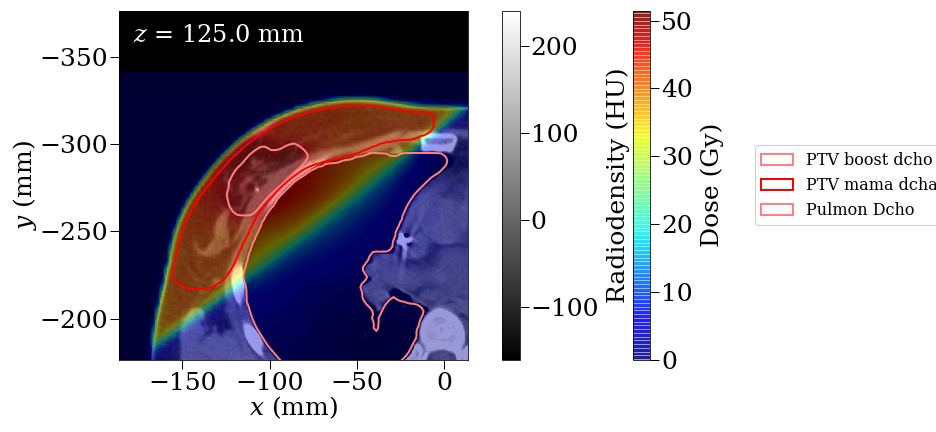

## Histogramas dosis volumen

Como ya hemos indicado en **Fundamentos** visualizar la dosis permite valorar su distribución espacial pero no es un método sencillo de realizar evaluaciones cuantitativas. 

En las celdas siguientes mostraremos gráficas de *DVH*, histograma dosis volumen, para ayudar a comprender en qué consisten estos objetos.

Comenzamos introduciendo una identificación de las estructuras relevantes

In [7]:
ptvboost, ptvmama, pulmonder = 7, 8, 9

`scikit-rt` proporciona herramientas para obtener y representar *DVH*s a partir de una distribución de dosis y un conjunto de estructuras. La siguiente celda muestra un ejemplo de cómo hacerlo para el plan `suma`

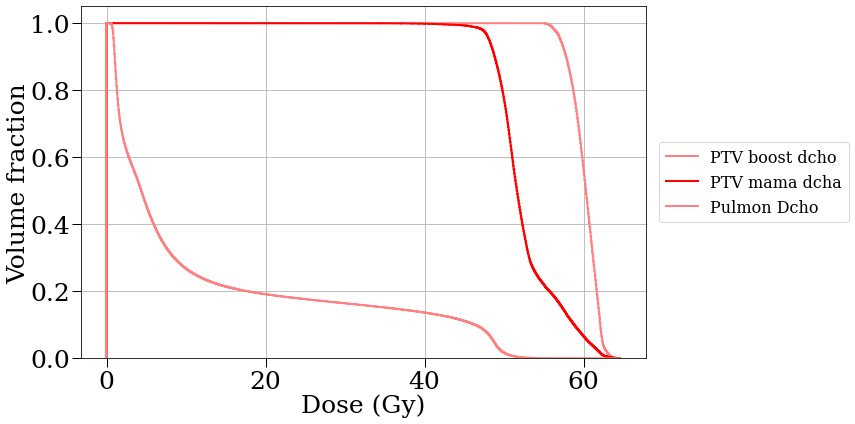

In [8]:
plan_ID = suma
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));

La figura anterior muestra los *DVH*s pero no nos da valores concretos sobre los mismos. Para poder realizar una evaluadción más detallada necesitamos utilizar algunas funciones de otro modulo orientado a la radioterapia denominado `dicompylercore`

In [9]:
from dicompylercore import dvh, dvhcalc

El objeto `dvhcalc` tiene un método denominado `get_dvh` que devuelve un objeto `dvh` correspondiente a una estructura dada dentro de un conjunto de estructuras y una distribución de dosis.

En la siguiente celda identificamos los archivos DICOM con las estructuras y las distribuciones de dosis

In [10]:
# Archivo DICOM de estructuras: órganos blanco y órganos de riesgo
dcm_ss = '../data/MamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm'
# Archivos DICOM de distribuciones de dosis
dcm_dose_mama = '../data/MamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.56180825880144060698193516247443136422.dcm'
dcm_dose_boost = '../data/MamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.488893207455186615011534392364350689689.dcm'
dcm_dose_suma = '../data/MamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm'
dcm_dose_SIB = '../data/MamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.52708297311437444114737711031232263301.dcm'

La siguiente celda sirve para definir los índices de las estructuras relevantes según figuran en el archivo DICOM

In [11]:
dcm_ptvboost, dcm_ptvmama, dcm_pulmonder = 14, 15, 16

Con estas identificaciones para obtener el *DVH* correspondiente al PTV boost dcho en la distribución de dosis del plan `suma` tendremos que escribir

In [12]:
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_suma, dcm_ptvboost)

El objeto `dvh` creado tiene muchos métodos útiles para hacer evaluaciones cuantitativas. Una primera reducción de información se puede obtener mediante el método `describe`. Por ejemplo la celda siguiente muestra el resumen correspondiente a `ptv_boost` recién creado

In [13]:
ptvboost_dvh.describe()

Structure: PTV boost dcho
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    34.62 cm3
Max Dose:  63.92 Gy
Min Dose:  55.69 Gy
Mean Dose: 60.21 Gy
D100:      55.68 Gy
D98:       56.51 Gy
D95:       57.15 Gy
D2cc:      62.38 Gy


Dado que un *DVH* es una curva que relaciona dosis con volumen, los objetivos de prescripción y las restricciones de dosis que se imponen sobre los *DVH* pueden venir expresadas de dos maneras diferentes:

- **Dxx** nos dice la dosis que recibe un volumen **xx**. Si **xx** se expresa sin unidades se refiere a un porcentaje de volumen respecto al volumen total del órgano. Si se da con unidades se refiere lógicamente a volumen medido en esas unidades. Las propias dosis se pueden dar en valor absoluto medido en las unidades de dosis correspondiente o en valores relativos respecto a la dosis de prescripción del tratamiento.
- **Vxx** nos dice el volumen de órgano que recibe la dosis **xx**. En este caso lo más habitual es que si no aparecen unidades se refiera a un valor de dosis en Gy. Por ejemplo un V20 inferior al 25% indicaría que se intenta conseguir que la dosis de 25 Gy sea recibida por menos del 25% del volumen del órgano afectado.

Las siguientes celdas muestran ejemplos de cómo *interrogar* a los objetos `dvh` sobre estos parámetros

In [14]:
ptvboost_dvh.D5

dvh.DVHValue(62.45, 'Gy')

In [15]:
ptvboost_dvh.relative_volume.statistic('V62.45Gy')

dvh.DVHValue(4.963898916967509, '%')

In [16]:
ptvboost_dvh.statistic('V62.45Gy')

dvh.DVHValue(1.71875, 'cm3')

### Cuestiones

9. **Realizar una evaluación de los siguientes criterios de prescripcioón de tratamiento y de tolerabilidad del tratamiento sobre el plan correspondiente**


| Plan | Volumen | Criterio |
|----|-----|------|
|Mama | PTV mama dcha | Al menos 95% cubierto por el 95% de la dosis de prescripción (50 Gy) |
| | PTV mama dcha | No más del 5% cubierto por el 107% de la dosis de prescripción (50 Gy) |
| | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (50 Gy) |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (50 Gy) |
| | Pulmón | Volumen de órgano que recibe 20 Gy o más inferior al 25% |
|Boost | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (10 Gy) |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (10 Gy) |
|Suma | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (60 Gy) |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (60 Gy) |
| | Pulmón | Volumen de órgano que recibe 20 Gy o más inferior al 25% |
|SIB | PTV mama dcha | Al menos 95% cubierto por el 95% de la dosis de prescripción (40 Gy) |
| | PTV mama dcha | No más del 5% cubierto por el 107% de la dosis de prescripción (40 Gy) |
| | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (48 Gy) |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (48 Gy) |
| | Pulmón | Volumen de órgano que recibe 18 Gy o más inferior al 25% |


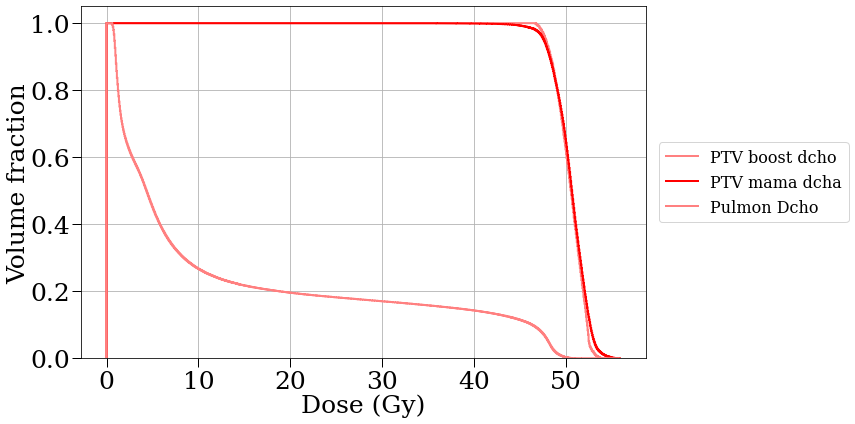

In [19]:
#plan mama
plan_ID = mama
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_mama, dcm_ptvboost)
ptvmama_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_mama, dcm_ptvmama)
pulmonder_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_mama, dcm_pulmonder)

In [20]:
print(ptvmama_dvh.D95)
print(ptvmama_dvh.D5)
print(ptvboost_dvh.D95)
print(ptvboost_dvh.D5)
print(pulmonder_dvh.relative_volume.statistic('V20Gy'))

47.70 Gy
53.09 Gy
47.65 Gy
52.50 Gy
19.60 %



| Plan | Volumen | Criterio | Evaluación | Porcentaje de dosis real | ¿Se cumple? |
|----|-----|------|-------|--------|---------|
|Mama | PTV mama dcha | Al menos 95% cubierto por el 95% de la dosis de prescripción (50 Gy) | D95 = 47.70 Gy | 95.4% | Sí |
| | PTV mama dcha | No más del 5% cubierto por el 107% de la dosis de prescripción (50 Gy) | D5 = 53.09 Gy | 106.2% | Sí |
| | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (50 Gy) | D95 = 47.65 Gy | 95.3% | Sí |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (50 Gy) | D5 = 52.50 Gy | 105.0 % | Sí |
| | Pulmón | Volumen de órgano que recibe 20 Gy o más inferior al 25% | D19.75 = 20 Gy | | Sí |

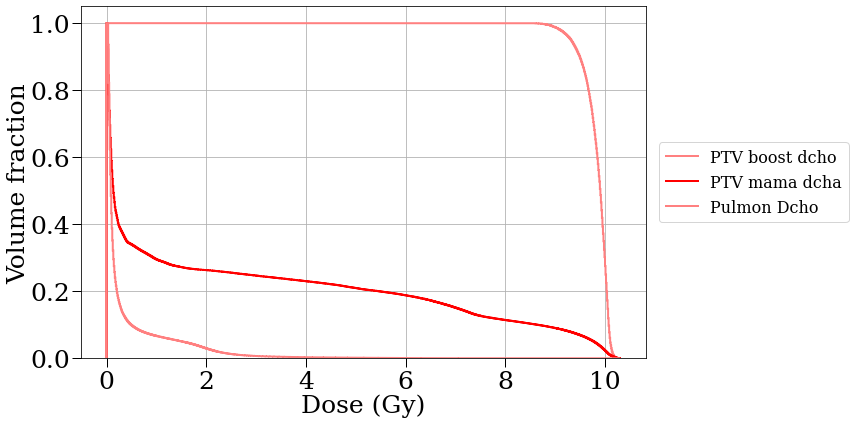

9.38 Gy
10.12 Gy


In [23]:
#plan boost
plan_ID = boost
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_boost, dcm_ptvboost)
ptvmama_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_boost, dcm_ptvmama)
pulmonder_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_boost, dcm_pulmonder)
print(ptvboost_dvh.D95)
print(ptvboost_dvh.D5)              

| Plan | Volumen | Criterio | Evaluación | Porcentaje de dosis real | ¿Se cumple? |
|----|-----|------|-------|--------|---------|
|Boost | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (10 Gy) | D95 = 9.38 Gy | 93.8% | No |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (10 Gy) | D5 = 10.12 Gy | 101.2% | Sí |

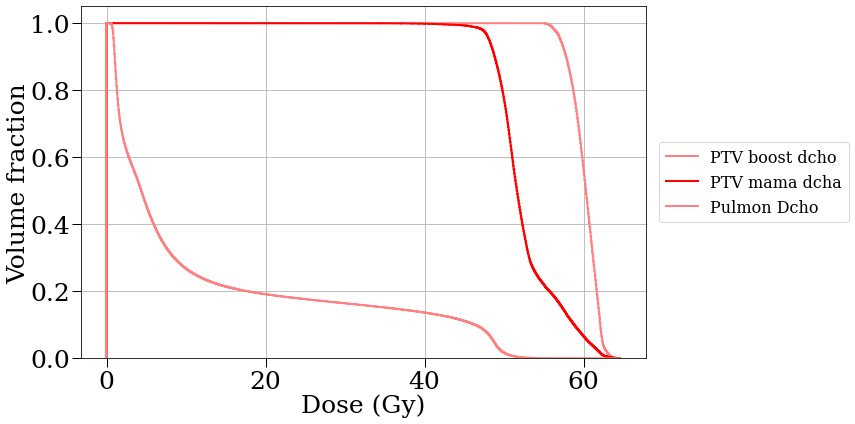

57.15 Gy
62.45 Gy
19.75 %


In [24]:
#plan suma
plan_ID = suma
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_suma, dcm_ptvboost)
ptvmama_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_suma, dcm_ptvmama)
pulmonder_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_suma, dcm_pulmonder)
print(ptvboost_dvh.D95)
print(ptvboost_dvh.D5)
print(pulmonder_dvh.relative_volume.statistic('V20Gy'))

| Plan | Volumen | Criterio | Evaluación | Porcentaje de dosis real | ¿Se cumple? |
|----|-----|------|-------|--------|---------|
|Suma | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (60 Gy) | D95 = 57.15 Gy | 95.3% | Sí |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (60 Gy) | D5 = 62.45 Gy | 104.1% | Sí |
| | Pulmón | Volumen de órgano que recibe 20 Gy o más inferior al 25% | D19.75 = 20 Gy | | Sí |

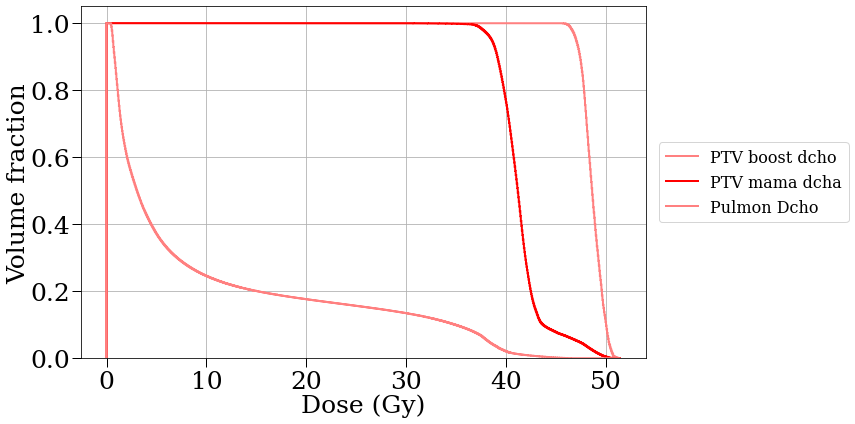

38.60 Gy
47.35 Gy
47.20 Gy
50.39 Gy
18.86 %


In [29]:
#plan SIB
plan_ID = SIB
dose = patient.studies[0].ct_doses[plan_ID]
dose.plot_dvh([ss1[ptvboost], ss1[ptvmama], ss1[pulmonder]], bins=1000, figsize=(12,6));
ptvboost_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_ptvboost)
ptvmama_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_ptvmama)
pulmonder_dvh = dvhcalc.get_dvh(dcm_ss, dcm_dose_SIB, dcm_pulmonder)
print(ptvmama_dvh.D95)
print(ptvmama_dvh.D5)
print(ptvboost_dvh.D95)
print(ptvboost_dvh.D5)
print(pulmonder_dvh.relative_volume.statistic('V18Gy'))

| Plan | Volumen | Criterio | Evaluación | Porcentaje de dosis real | ¿Se cumple? |
|----|-----|------|-------|--------|---------|
|SIB | PTV mama dcha | Al menos 95% cubierto por el 95% de la dosis de prescripción (40 Gy) | D95 = 38.60 Gy | 96.5% | Sí |
| | PTV mama dcha | No más del 5% cubierto por el 107% de la dosis de prescripción (40 Gy) | D5 = 47.35 Gy | 118.3% | No |
| | PTV boost dcho | Al menos 95% cubierto por el 95% de la dosis de prescripción (48 Gy) | D95 = 47.20 Gy | 98.3% | Sí |
| | PTV boost dcho | No más del 5% cubierto por el 107% de la dosis de prescripción (48 Gy) | D5 = 50.39 Gy | 105.0% | Sí |
| | Pulmón | Volumen de órgano que recibe 18 Gy o más inferior al 25% | D18.86 = 18 Gy | | Sí |

# Radiobiología
## Fraccionamiento y equivalencia de tratamientos

En esta parte del cuaderno queremos utilizar el modelo lineal cuadrático para justificar los valores de prescripción y de restricción sobre el pulmón que hemos utilizado en el apartado anterior.

Según el modelo lineal cuadrático una dosis absorbida $D$ administrada en un número de fracciones $n$ produce una dosis biológica equivalente $DBE$ dada por
\begin{equation}
DBE = D\,(1 + \frac{D/n}{\alpha/\beta}) 
\end{equation}

donde el cociente $\alpha/\beta$ [Gy] es un parámetro específico del tejido que recibe la dosis.

Dos esquemas de tratamiento son equivalentes si producen la misma $DBE$.

### Cuestiones
Considerar un $\alpha/\beta = 3$ tanto para el tejido de la mama como para el pulmón.
10. **Calcular qué dosis se tiene que administrar al volumen PTV boost dcho si se quiere realizar el tratamiento en lugar de en forma secuencial, 25+5 fracciones, en forma concurrente, 25 fracciones.**

Despejamos D de la fórmula de DBE:
\begin{equation}
DBE = D\,(1 + \frac{D/n}{\alpha/\beta}) 
\end{equation}
Donde queda:
\begin{equation}
D=\frac{-n \alpha/\beta \pm \sqrt{(n\alpha/\beta)^2+4nDBE \alpha/\beta}}{2}
\end{equation}
Para poder calcular su valor numérico, calculamos el valor de DBE con los datos del enunciado:

\begin{equation}
DBE = 50\,(1 + \frac{50/25}{3}) + 10\,(1 + \frac{10/5}{3}) = 100 Gy
\end{equation}
  Y con estos valores, dan unos valores para las dosis de: $D_1=-131.9 Gy$ y $D_2=56.9 Gy$, donde solo tiene sentido la dosis positiva: **D=56.9 Gy**

1. **Repetir el cálculo anterior si queremos acelerar el tratamiento a 15 fracciones.** La diferencia con el apartado anterior será que ahora n=15, dando: **D=48.3 Gy**

1. **Calcular para el tratamiento concurrente en 15 fracciones cuál es la nueva restricción que se tiene que imponer sobre el pulmón para tener la misma probablidad de complicaciones que aceptamos en el tratamiento secuencial.**  Volvemos a calcular DBE con nuevos valores. En este caso será D=20 Gy porque no más del 25% del volumen debe recibir esa dosis. También n cambiará a valer 30, ya que la restricción es en ambos tratamientos. Con estos nuevos valores: DBE=24.4 Gy. Ahora calculamos la dosis igual que en el apartado anterior, dando: **D=17.6 Gy**. Esta será la dosis que debe recibir al menos el 25% del volumen del pulmón.




## Comparación de planes mediante DVHs

Los histogramas dosis volumen se pueden almacenar en bruto en archivos de datos (csv, excel, etc). En investigación a menudo se analizan colecciones de DVHs para obtener conclusiones.

En esta parte del cuaderno vamos a trabajar con los DVHs del tratamiento integrado y de la suma de las partes del tratamiento secuencial para analizar su equivalencia.

Ejecutando la siguiente celda descargamos el archivo `DVHs.xlsx` en formato Excel con los dos DVHs en la carpeta `data`

El archivo Excel tiene una hoja por cada tipo de tratamiento nombradas por la dosis media que debería recibir el PTV boost dcho como 48 Gy y 60 Gy respectivamente.

Los datos están en columnas con encabezados descriptivos:
- **Dr**: Dosis relativa a la dosis media del ptvBoost
- **D**: Dosis absoluta
- **Boost**: Dosis en el PTV boost dcho
- **Mama**: Dosis en el PTV mama dcha
- **Pulmon**: Dosis en en Pulmon Dcho

In [31]:
# Descargar los datos compartidos de Google Drive
url = 'https://docs.google.com/spreadsheets/d/1GHyqh1MGdUisjAH0kltUAtf9bktWhaM9/edit?usp=sharing&ouid=109366532745677997406&rtpof=true&sd=true'
output = '../data/DVHs.xlsx'
gdown.download(url, output, quiet=False, fuzzy=True);

Downloading...
From: https://drive.google.com/uc?id=1GHyqh1MGdUisjAH0kltUAtf9bktWhaM9
To: /home/jovyan/data/DVHs.xlsx
100%|██████████| 67.3k/67.3k [00:00<00:00, 10.1MB/s]


En python una buena forma de manejar datos en formato Excel es mediante el módulo `pandas`.

Este módulo lee la hoja indicada por `sheet_name` y almacena los datos en un objeto de tipo `DataFrame` que dispone de muchos métodos para manipular y visualizar sus datos.

Para hacer gráficos el módulo de referencia es `matplotlib.pyplot`

Importamos `pandas` y `matplotlib.pyplot`

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

Leemos los datos de los histogramas en sendos DataFrames

In [33]:
dvhSumadf = pd.read_excel('../data/DVHs.xlsx', sheet_name='60Gy')
dvhSIBdf = pd.read_excel('../data/DVHs.xlsx', sheet_name='48Gy')

Representamos los histogramas. Cada curva la podemos representar mediante el método `plot.line`  del correspondiente DataFrame. 

Para que todas las curvas aparezcan en la misma gráfica necesitamos un objeto `axis` que creamos mediante el método `subplots` de `matplollib.pyplot`

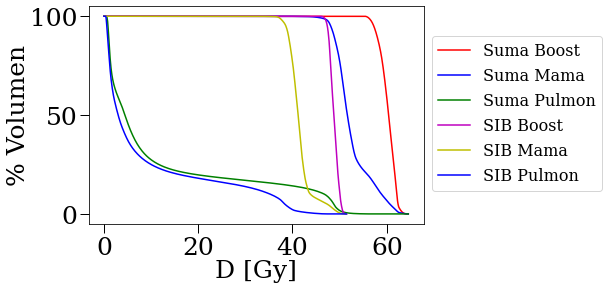

In [34]:
fig, ax = plt.subplots()

dvhSumadf.plot.line(x='D', y='Boost', color='r', ax=ax, label='Suma Boost')
dvhSumadf.plot.line(x='D', y='Mama', color='b', ax=ax, label ='Suma Mama')
dvhSumadf.plot.line(x='D', y='Pulmon', color='g', ax=ax, label='Suma Pulmon')

dvhSIBdf.plot.line(x='D', y='Boost', color='m', ax=ax, linestyle='-', label='SIB Boost')
dvhSIBdf.plot.line(x='D', y='Mama', color='y', ax=ax, label='SIB Mama')
dvhSIBdf.plot.line(x='D', y='Pulmon', color='b', ax=ax, label='SIB Pulmon')

plt.legend(bbox_to_anchor=(1., 0.9))

ax.set_ylabel('% Volumen')
ax.set_xlabel('D [Gy]')

plt.show()

La figura anterior nos permite visualizar simultáneamente las dosis de dos tratamientos distintos, pero no son directamente comparables porque tienen fraccionamientos diferentes.

### Cuestiones
Los procedimientos para calcular los apartados a continuación están hechos debajo.
Añadir a cada DataFrame una columna con la **DBE** dosis biológica equivalente correspondiente a la dosis $D$. Representar gráficamente los histogramas en  una figura en función de la **DBE**

13. **Analizar la equivalencia de los tratamientos expresados en *DBE*:**
Para cada elemento:
- *Boost:* Como vemos en la gráfica de abajo, el tratamiento suma hace que el boost se lleve en casi el 100% de su volumen unos 90 Gy. También nos indica que el 50% recibe también 100 Gy o más. Por otro lado, el tratamiento SIB aplica un rango menor de dosis, más concentrado en torno a los 100 Gy, lo que hace que tenga un cambio de dosis máxima a 0 más pronunciado.
- *Mama:* Para el tratamiento suma, la gran mayoría de su volumen (en torno al 70%) recibe aproximadamente 70 Gy, y sobre el 30% del volumen, hay un cambio en la pendiente de la gráfica (a partir de 85 Gy), haciendo que llegue a recibir unas dosis mucho mayores. El tratamiento SIB presenta una caída más pronunciada, y hace que un menor porcentaje del volumen reciba las dosis altas de las que se hablaba en el tratamiento suma. Por lo tanto, el tratamiento suma aplica más dosis a más volumen que el tratamiento SIB.
- *Pulmón:* Este es el órgano que menos dosis recibe. Para el tratamiento suma, solo el 50% recibe una pequeña dosis de unos 5 Gy, y según va aumentando la dosis recibida, a menor volumen afecta. En este caso, el tratamiento SIB presenta incluso menor volumen expuesto a altas dosis respecto al suma.
1. **Definiendo conformación de la dosis como el grado de solapamiento espacial entre la distribución de la dosis y los volúmenes de tratamiento, ¿qué esquema de tratamiento produce una mejor conformación? Razonar la respuesta comentando las diferencias en los DVHs de los tres volúmenes.**  
1. Repetir la cuestión anterior pero en términos de la **DBEQ2**
1. Hacer una representación de los DVHs para el tratamiento secuencial en términos de la dosis $D$ y de **DBEQ2** y explicar porque no coinciden a pesar de que el concepto **DBEQ2** se introdujo para que los Oncólogos de Radioterapia pudieran comparar tratamientos realizados en fraccionamiento estándar de 2 Gy, que es cómo se ha realizado el tratamiento Suma.

In [36]:
#añadimos el DataFrame
dvhSumadf['DBE']=dvhSumadf.D*(1+dvhSumadf.D/30/3)
dvhSIBdf['DBE'] =dvhSIBdf.D*(1+dvhSIBdf.D/15/3)

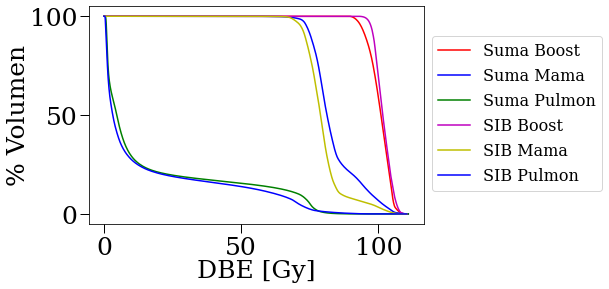

In [37]:
#Apartado 13
fig, ax=plt.subplots()
dvhSumadf.plot.line(x='DBE', y='Boost', color='r', ax=ax, label='Suma Boost')
dvhSumadf.plot.line(x='DBE', y='Mama', color='b', ax=ax, label='Suma Mama')
dvhSumadf.plot.line(x='DBE', y='Pulmon', color='g', ax=ax, label='Suma Pulmon')

dvhSIBdf.plot.line(x='DBE', y='Boost', color='m', ax=ax, linestyle='-', label='SIB Boost')
dvhSIBdf.plot.line(x='DBE', y='Mama', color='y', ax=ax, label='SIB Mama')
dvhSIBdf.plot.line(x='DBE', y='Pulmon', color='b', ax=ax, label='SIB Pulmon')
plt.legend(bbox_to_anchor=(1., 0.9))
ax.set_ylabel('% Volumen')
ax.set_xlabel('DBE [Gy]')
plt.show()

### Cuestión

17. Estudiar qué efecto tiene el fraccionamiento sobre la tolerabilidad del tratamiento si el α/β del pulmón fuera diferente al de la mama y al del tejido tumoral. Considerar un rango de variación α/β ∈ (1, 10)

## Propuestas *premium*

Cuestiones voluntarias, desarrollos interesantes que requieren tener conocimientos básicos de python

1. Desarrollar un gráfico que permita visualizar la distribución de dosis de forma interactiva y en en el se pueda seleccionar el intervalo de dosis $(D_{min}, D_{max})$, es decir, un gráfico en el se se visualizan por ejemplo las dosis comprendidas entre el 95% y el 107% de la dosis de prescripción.
1. Desarrollar un gráfico en el que se represente la dosis biológica equivalente de los distintos esquemas de tratamiento. 